[ 6153.87369124  3757.28112313 19801.13022094]
0.00039215
[2.41324157 1.47341779 7.76501322]
F1_array shape: (3,)


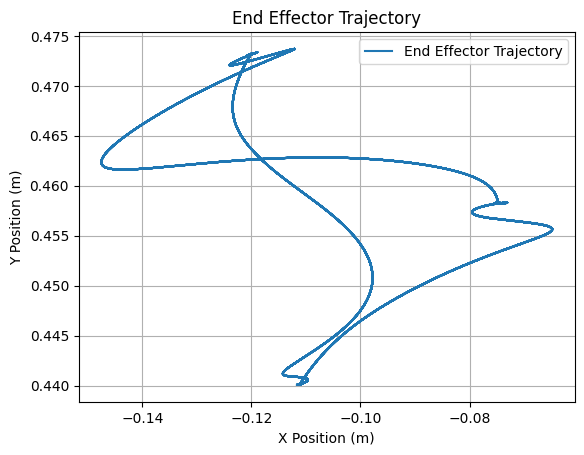

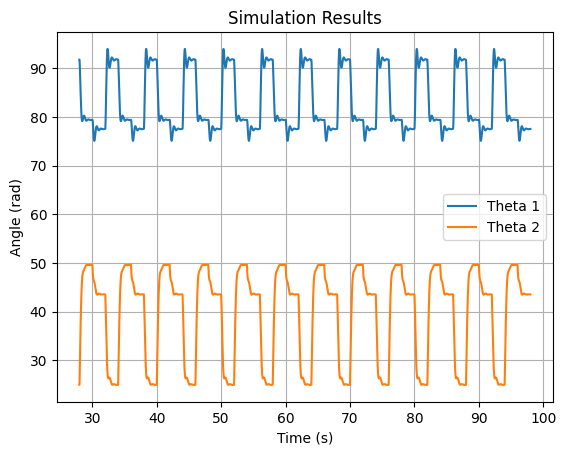

In [1]:
import mujoco
import datetime
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

path = "../../../models/v2_4/urdf/dog2_4singleLeg_realconstrast.xml"

ExpName = f"AtoB_realsim_constrast_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}"
m = mujoco.MjModel.from_xml_path(path)
d = mujoco.MjData(m)

RB_BAA_SlideJoint_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_JOINT, "RB_BAA_SlideJoint")
RB_BAA_FM_SlideJoint_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_JOINT, "RB_BAA_FM_SlideJoint")
RB_MAA_SlideJoint_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_JOINT, "RB_MAA_SlideJoint")
RB_MAA_FM_SlideJoint_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_JOINT, "RB_MAA_FM_SlideJoint")
RB_shoulder_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_JOINT, "RB_shoulder")
RB_Elbow_id = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_JOINT, "RB_Elbow")

def l_calulator(theta_1, theta_2):
    a_1 = 0.25
    a_2 = 0.25
    b_1 = 0.21213
    b_2 = 0.1
    d_1 = 0.06
    d_2 = 0.10

    beta_1 = 8.13 / 180 * np.pi
    beta_2 = 30 / 180 * np.pi

    A_x_O = d_1
    A_y_O = 0

    B_x_O = -d_2
    B_y_O = 0

    C_x_O = b_1 * np.cos(theta_1 - beta_1)
    C_y_O = b_1 * np.sin(theta_1 - beta_1)

    D_x_O = a_1 * np.cos(theta_1) + b_2 * np.cos(theta_1 + theta_2 + beta_2)
    D_y_O = a_1 * np.sin(theta_1) + b_2 * np.sin(theta_1 + theta_2 + beta_2)

    l_1 = np.sqrt((A_x_O - C_x_O)**2 + (A_y_O - C_y_O)**2)
    l_2 = np.sqrt((B_x_O - D_x_O)**2 + (B_y_O - D_y_O)**2)

    return l_1, l_2

def bias_calculator(l_10, l_20):
  l_1, l_2 = l_calulator(math.pi/2, math.pi/2)
  l1_rel = l_10 - l_1
  l2_rel = l_20 - l_2
  return l1_rel/2, l2_rel/2


P1_array = np.array([6.153873691241822, 3.757281123127819, 19.801130220938756])*1000
P2_array = np.array([2.7282463188213035, 7.2611504152265525, 8.519687913683074])*1000

viewer_flag = 0

def run_single_experiment(params, P1_array=P1_array, P2_array=P2_array, time_exp = 100, time_step = 2):
    """
        :param params: (damping_MAA, damping_BAA, exp_id)
    """
    try:
        stiffness_MAA, stiffness_BAA, l10, l20, damping_MAA, damping_BAA, s1, s2, c1_thigh, c2_calf = params
        
        m = mujoco.MjModel.from_xml_path(path)
        d = mujoco.MjData(m)
        print(P1_array)
        print(s1)

        F1_array = P1_array * s1
        F2_array = P2_array * s2
        print(F1_array)
        print(f"F1_array shape: {F1_array.shape}")

        for joint_id, stiffness, damping in zip(
            [RB_BAA_SlideJoint_id, RB_BAA_FM_SlideJoint_id, RB_MAA_SlideJoint_id, RB_MAA_FM_SlideJoint_id],
            [stiffness_BAA, stiffness_BAA, stiffness_MAA, stiffness_MAA],
            [damping_BAA, damping_BAA, damping_MAA, damping_MAA]
        ):
            m.jnt_stiffness[joint_id] = stiffness * 2
            m.dof_damping[joint_id] = damping * 2

        MAA_bias, BAA_bias = bias_calculator(l10, l20)
        for joint_id, bias in zip(
            [RB_BAA_SlideJoint_id, RB_BAA_FM_SlideJoint_id, RB_MAA_SlideJoint_id, RB_MAA_FM_SlideJoint_id],
            [BAA_bias, BAA_bias, MAA_bias, MAA_bias]
        ):
            m.qpos_spring[joint_id] = bias

        m.dof_damping[RB_shoulder_id] = c1_thigh
        m.dof_damping[RB_Elbow_id] = c2_calf

        d.ctrl = np.zeros_like(d.ctrl)
        mujoco.mj_step(m, d)

        # Experiment Settings
        ExpResultList = []
        

        start = time.time() if viewer_flag else d.time
        i = 0
        try:
            while (d.time - start) < time_exp:  # viewer.is_running() and
                step_time = time.time() if viewer_flag else d.time

                i = int((d.time - start)//time_step)
                d.ctrl[:2] = F1_array[i%3]
                d.ctrl[2:] = F2_array[i%3]

                Position = np.array(d.qpos)
                res = np.hstack((d.time, Position))
                ExpResultList.append(res)

                mujoco.mj_step(m, d)  # update!
                if viewer_flag:
                    time_until_next_step = m.opt.timestep - (time.time() - step_time)
                    if time_until_next_step > 0:
                        time.sleep(time_until_next_step)

        except KeyboardInterrupt:
            pass
        
        # data process
        result_array = np.array(ExpResultList)
        time_sim = result_array[:,0]-time_step
        theta1_sim = (result_array[:,1]+math.pi/2)*180/np.pi
        theta2_sim = (result_array[:,2]+math.pi/2)*180/np.pi
        return time_sim, theta1_sim, theta2_sim
    
    except Exception as e:
        print(f"Error: {e}")
        raise e

k1=208.2599
k2=129.6576
l10=0.1741
l20=0.2605
c1=15.0718
c2=25.7807
s1=0.00039215
s2=0.00042904
c1_thigh=0.4224
c2_calf=0.1039
para = [k1, k2, l10, l20, c1, c2, s1, s2, c1_thigh, c2_calf]

time_sim, theta1_sim, theta2_sim = run_single_experiment(para, P1_array, P2_array, time_exp=100, time_step=2)

a_1 = 0.25
a_2 = 0.25
x_pos = a_1*np.cos(theta1_sim*math.pi/180) + a_2*np.cos(theta1_sim*math.pi/180 + theta2_sim*math.pi/180)
y_pos = a_1*np.sin(theta1_sim*math.pi/180) + a_2*np.sin(theta1_sim*math.pi/180 + theta2_sim*math.pi/180)
# Plotting the results
plt.figure()
slice_start = 6000  # 6s
plt.plot(x_pos[slice_start:], y_pos[slice_start:], label='End Effector Trajectory')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('End Effector Trajectory')
plt.legend()
plt.grid()


plt.figure()
plt.plot(time_sim[slice_start:], theta1_sim[slice_start:], label='Theta 1')
plt.plot(time_sim[slice_start:], theta2_sim[slice_start:], label='Theta 2')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Simulation Results')
plt.legend()
plt.grid()
plt.show()

In [4]:
# load real data（1.20）TriStatic_2025-01-21_19-26-44_A2B_data.csv
import pandas as pd
tri_real_data = pd.read_csv("./data/TriStatic_2025-01-21_19-26-44_A2B_data.csv")
print(tri_real_data)

      relative_time  pressure1_start  pressure2_start  pressure1_end  \
0          0.016814      6153.873691      2728.246319    3757.281123   
1          0.027337      6153.873691      2728.246319    3757.281123   
2          0.037337      6153.873691      2728.246319    3757.281123   
3          0.048337      6153.873691      2728.246319    3757.281123   
4          0.059337      6153.873691      2728.246319    3757.281123   
...             ...              ...              ...            ...   
5697       1.956875     19801.130221      8519.687914    6153.873691   
5698       1.966875     19801.130221      8519.687914    6153.873691   
5699       1.976875     19801.130221      8519.687914    6153.873691   
5700       1.987870     19801.130221      8519.687914    6153.873691   
5701       1.998870     19801.130221      8519.687914    6153.873691   

      pressure2_end    base_x    base_y  base_theta10  thigh_theta20  \
0       7261.150415  0.253863  0.589171      0.283078      74.1

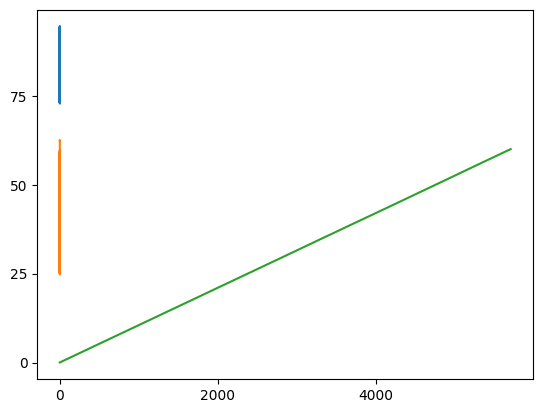

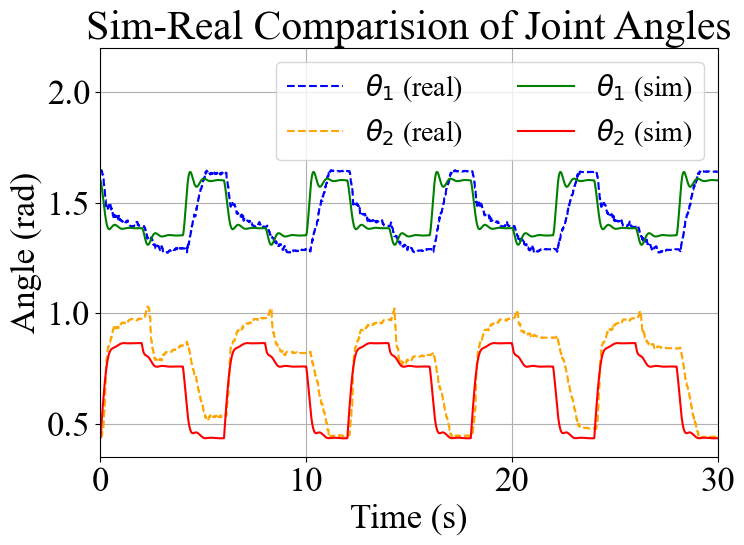

RMSE_theta1: 0.0915098788965774 
 RMSE_theta2: 0.1748216595349007 
 MAE_theta1: 0.06648760591984851 
 MAE_theta2: 0.1324528784471657 
 MaxAE_theta1: 0.31075397054176546 
 MaxAE_theta2: 0.5407107114369488


In [5]:
time_real = tri_real_data['relative_time'].values
theta1_real = tri_real_data['thigh_theta21'].values
theta2_real = tri_real_data['calf_theta32'].values

data_length = 100000

plt.plot(time_real[:data_length], theta1_real[:data_length], label='Real Theta 1')
plt.plot(time_real[:data_length], theta2_real[:data_length], label='Real Theta 2')

# rebuild the time series
for i in range(len(time_real)-1):
    if time_real[i+1] < time_real[i]:
        time_real[i+1] += int((time_real[i] - time_real[i+1])//2)*2 + 2
plt.plot(time_real[:data_length])

time_bias = time_sim[slice_start]
from matplotlib import rcParams

config = {
    "font.family":'Times New Roman', 
    "axes.unicode_minus": False,
    "font.size": 25,
}
rcParams.update(config)

time_real_consider = time_real[:data_length]-time_bias
time_sim_consider = time_sim[slice_start:]-time_bias
theta1_real_consider = theta1_real[:data_length] * np.pi/180
theta2_real_consider = theta2_real[:data_length] * np.pi/180
theta1_sim_consider = theta1_sim[slice_start:] * np.pi/180
theta2_sim_consider = theta2_sim[slice_start:] * np.pi/180

plt.figure(figsize=(8, 6))
plt.plot(time_real_consider, theta1_real_consider, label=r'$\theta_1$ (real)', color='blue', linestyle = '--')
plt.plot(time_real_consider, theta2_real_consider, label=r'$\theta_2$ (real)', color='orange', linestyle = '--')
plt.plot(time_sim_consider, theta1_sim_consider, label=r'$\theta_1$ (sim)', color='green', linestyle = '-')
plt.plot(time_sim_consider, theta2_sim_consider, label=r'$\theta_2$ (sim)', color='red', linestyle = '-')

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
# plt.title('Triangular Open-Loop Trajectory Control')
plt.axis([0, 30, 0.35, 2.2])
# plt.legend(loc='upper right')
plt.legend(
    loc='upper right',
    # bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    frameon=True,
    fontsize=20,
)
plt.grid(True)
plt.title('Sim-Real Comparision of Joint Angles')
plt.tight_layout()
plt.savefig('./figure/tri_trajectory.png', dpi=200, bbox_inches='tight')
plt.show()

# # calculate error: 0~40s 100Hz
time_consider = np.arange(0, 40, 0.01)
theta1_real_consider = np.interp(time_consider, time_real_consider, theta1_real_consider)
theta2_real_consider = np.interp(time_consider, time_real_consider, theta2_real_consider)
theta1_sim_consider = np.interp(time_consider, time_sim_consider, theta1_sim_consider)
theta2_sim_consider = np.interp(time_consider, time_sim_consider, theta2_sim_consider)
theta1_error = theta1_real_consider - theta1_sim_consider
theta2_error = theta2_real_consider - theta2_sim_consider

# RMSE, MAE, MaxAE
RMSE_theta1 = np.sqrt(np.mean(theta1_error**2))
RMSE_theta2 = np.sqrt(np.mean(theta2_error**2))
MAE_theta1 = np.mean(np.abs(theta1_error))
MAE_theta2 = np.mean(np.abs(theta2_error))
MaxAE_theta1 = np.max(np.abs(theta1_error))
MaxAE_theta2 = np.max(np.abs(theta2_error))
print(f"RMSE_theta1: {RMSE_theta1} \n",
      f"RMSE_theta2: {RMSE_theta2} \n",
      f"MAE_theta1: {MAE_theta1} \n",
      f"MAE_theta2: {MAE_theta2} \n",
      f"MaxAE_theta1: {MaxAE_theta1} \n",
      f"MaxAE_theta2: {MaxAE_theta2}")
triangle_log = {
    "RMSE_theta1": RMSE_theta1,
    "RMSE_theta2": RMSE_theta2,
    "MAE_theta1": MAE_theta1,
    "MAE_theta2": MAE_theta2,
    "MaxAE_theta1": MaxAE_theta1,
    "MaxAE_theta2": MaxAE_theta2
}
# save
triangle_log = pd.DataFrame([triangle_log])
triangle_log.to_csv("./log/triangle_error.csv", index=False)